In [1]:
from __future__ import print_function 
%cd /Users/sophiatonelli/library_script/script
from scipy.ndimage import gaussian_filter1d
import tools21cm as t2c
import os, sys 
from scipy.interpolate import interp1d
from scipy.optimize import root_scalar
import math
from scipy.stats import gaussian_kde
os.chdir('/Users/sophiatonelli/library_script/script/work')
sys.path.append(os.getcwd())
import script
sys.path.append(os.getcwd())
import numpy as np 
import matplotlib.pyplot as plt 
import script 
import matplotlib
%matplotlib inline
matplotlib.rcParams.update({'font.size': 11})



/Users/sophiatonelli/library_script/script


In [2]:
"""
I aim to compare the resolution of the PC and ES methods for the ionization field.
I am using the same box size and ngrid for both methods.
I am using the same matter fields/snapshot for both methods.

To do so, here is the plan:
I am generating the ionization maps for both methods and plotting them.

Here 9 scenarios (with zeta efficiency halo mass independent) are plotted using,
PC method with ngrid 128 to display the diffeerent reionization fields at maximum resolution

ZETA VALS ARE SAVED IN NUMPY ARRAY
"""

'\nI aim to compare the resolution of the PC and ES methods for the ionization field.\nI am using the same box size and ngrid for both methods.\nI am using the same matter fields/snapshot for both methods.\n\nTo do so, here is the plan:\nI am generating the ionization maps for both methods and plotting them.\n\nHere 9 scenarios (with zeta efficiency halo mass independent) are plotted using,\nPC method with ngrid 128 to display the diffeerent reionization fields at maximum resolution\n\nZETA VALS ARE SAVED IN NUMPY ARRAY\n'

In [3]:

gadget_snap = '/Users/sophiatonelli/Downloads/snap_120' 
outpath = '/Users/sophiatonelli/library_script/script/work/script_files' 
scaledist = 1e-3 
default_simulation_data = script.default_simulation_data(gadget_snap, outpath, sigma_8=0.829, ns=0.961, omega_b=0.0482, scaledist=scaledist) 

print("Simulation box size:", default_simulation_data.box, "cMpc/h") 
print("Simulation redshift:", default_simulation_data.z)



Simulation box size: 256.0 cMpc/h
Simulation redshift: 8.0


In [4]:

#(i.e. resolution 256/128 cMpc/h)
ngrid = 42 #64 #128, 64, 32
matter_fields = script.matter_fields(default_simulation_data, ngrid, outpath, overwrite_files=False) 
list_xhi_vals = [0.2, 0.5, 0.7]      #target mean neutral fractions
list_log10Mmin_vals = [8.0, 9.0, 10.0]  #log10(Mmin)



In [5]:

#PC METHOD
#1: second method to find zeta
zeta_vals2 = []  #store all (Mmin, xhi) pairs
for log10Mmin in list_log10Mmin_vals:
    fcoll_arr = matter_fields.get_fcoll_for_Mmin(log10Mmin)
    fcoll_mean = fcoll_arr.mean()
    print(f"\nlog10(Mmin): {log10Mmin:.1f}  fcoll mean: {fcoll_mean:.4f}")

    for target_xhi in list_xhi_vals:
        #PHOTON CONSERVATION METHOD
        #ionization mean: <x_HII> = <qi(1+delta)> = <1 - target_xhi> == < zeta * fcoll(1+delta)> --> thus: zeta = (1 - target_xhi) / fcoll_mean where fcoll_mean= <fcoll(1+delta)>
        ionization_map = script.ionization_map(matter_fields)
        qi_arr = ionization_map.get_qi(fcoll_arr)

        delta= matter_fields.densitycontr_arr
        mean_qi = np.mean(qi_arr * (1 + delta))
        fcoll_mean = np.mean(fcoll_arr * (1 + delta))
        zeta_root2 = (1 - target_xhi) / fcoll_mean
        zeta_vals2.append(zeta_root2)
        try:
            print(f"✅ Found zeta: {zeta_root2} for log10Mmin: {log10Mmin:.1f} and target xhi: {target_xhi}")

        except ValueError:
            print(f"❌ No root found for log10Mmin: {log10Mmin:.1f} and target xhi: {target_xhi}")
            zeta_vals2.append(None)

print("\nAll zeta values (should be 9):", zeta_vals2)




log10(Mmin): 8.0  fcoll mean: 0.0464
✅ Found zeta: 16.227490734768995 for log10Mmin: 8.0 and target xhi: 0.2
✅ Found zeta: 10.142181709230622 for log10Mmin: 8.0 and target xhi: 0.5
✅ Found zeta: 6.085309025538375 for log10Mmin: 8.0 and target xhi: 0.7

log10(Mmin): 9.0  fcoll mean: 0.0183
✅ Found zeta: 40.12469013834109 for log10Mmin: 9.0 and target xhi: 0.2
✅ Found zeta: 25.077931336463177 for log10Mmin: 9.0 and target xhi: 0.5
✅ Found zeta: 15.046758801877909 for log10Mmin: 9.0 and target xhi: 0.7

log10(Mmin): 10.0  fcoll mean: 0.0038
✅ Found zeta: 187.87921772097275 for log10Mmin: 10.0 and target xhi: 0.2
✅ Found zeta: 117.42451107560797 for log10Mmin: 10.0 and target xhi: 0.5
✅ Found zeta: 70.4547066453648 for log10Mmin: 10.0 and target xhi: 0.7

All zeta values (should be 9): [16.227490734768995, 10.142181709230622, 6.085309025538375, 40.12469013834109, 25.077931336463177, 15.046758801877909, 187.87921772097275, 117.42451107560797, 70.4547066453648]


In [6]:
zeta_pc_vals = np.array(zeta_vals2)

#np.save('zeta_pc_array_redsh8.npy', zeta_pc_vals) #save zeta_es_array to a numpy to export it1 CHECK NGRID 64

In [7]:
print(zeta_pc_vals)

[ 16.22749073  10.14218171   6.08530903  40.12469014  25.07793134
  15.0467588  187.87921772 117.42451108  70.45470665]


Zeta array shape: (3, 3)
Zeta array:
 [[ 16.22749073  10.14218171   6.08530903]
 [ 40.12469014  25.07793134  15.0467588 ]
 [187.87921772 117.42451108  70.45470665]]


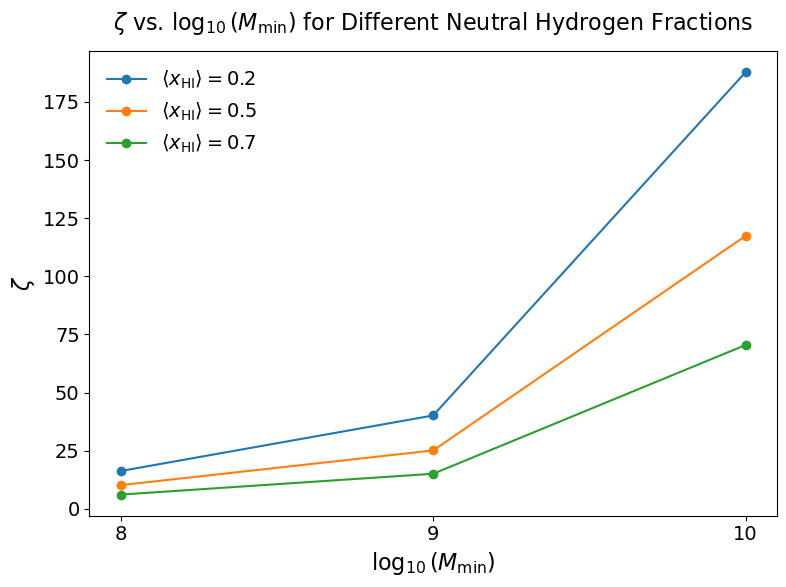

In [8]:

#2:
zeta_array = np.array(zeta_vals2).reshape(len(list_log10Mmin_vals), len(list_xhi_vals)) #do 3 rows and 3 columns reshape
print("Zeta array shape:", zeta_array.shape)
print("Zeta array:\n", zeta_array)

#plot: for each xhi, plot zeta vs log10Mmin
plt.figure(figsize=(8, 6))

for j, target_xhi in enumerate(list_xhi_vals):
    plt.plot(list_log10Mmin_vals, zeta_array[:, j], marker='o', label=rf"$\langle x_{{\mathrm{{HI}}}} \rangle = {target_xhi}$")

plt.xlabel(r'$\log_{10}(M_{\mathrm{min}})$', fontsize=16)
plt.ylabel(r'$\zeta$',fontsize=16)
plt.xticks(list_log10Mmin_vals)  #set x-ticks to match Mmin values
plt.tick_params(axis='both', which='major', labelsize=14)
plt.title(r'$\zeta$ vs. $\log_{10}(M_{\mathrm{min}})$ for Different Neutral Hydrogen Fractions', fontsize=16, pad=15)
plt.legend(frameon=False, fontsize=14)
plt.tight_layout()
plt.show()


log10(Mmin): 8.0 fcoll: 0.046404514
zeta: 16.227490734768995
qi_arr mean: 0.7722957
log10(Mmin): 8.0 fcoll: 0.046404514
zeta: 10.142181709230622
qi_arr mean: 0.471485
log10(Mmin): 8.0 fcoll: 0.046404514
zeta: 6.085309025538375
qi_arr mean: 0.28238678
log10(Mmin): 9.0 fcoll: 0.018346127
zeta: 40.12469013834109
qi_arr mean: 0.7715894
log10(Mmin): 9.0 fcoll: 0.018346127
zeta: 25.077931336463177
qi_arr mean: 0.46450168
log10(Mmin): 9.0 fcoll: 0.018346127
zeta: 15.046758801877909
qi_arr mean: 0.2762321
log10(Mmin): 10.0 fcoll: 0.0037661456
zeta: 187.87921772097275
qi_arr mean: 0.773292
log10(Mmin): 10.0 fcoll: 0.0037661456
zeta: 117.42451107560797
qi_arr mean: 0.45962998
log10(Mmin): 10.0 fcoll: 0.0037661456
zeta: 70.4547066453648
qi_arr mean: 0.26834342


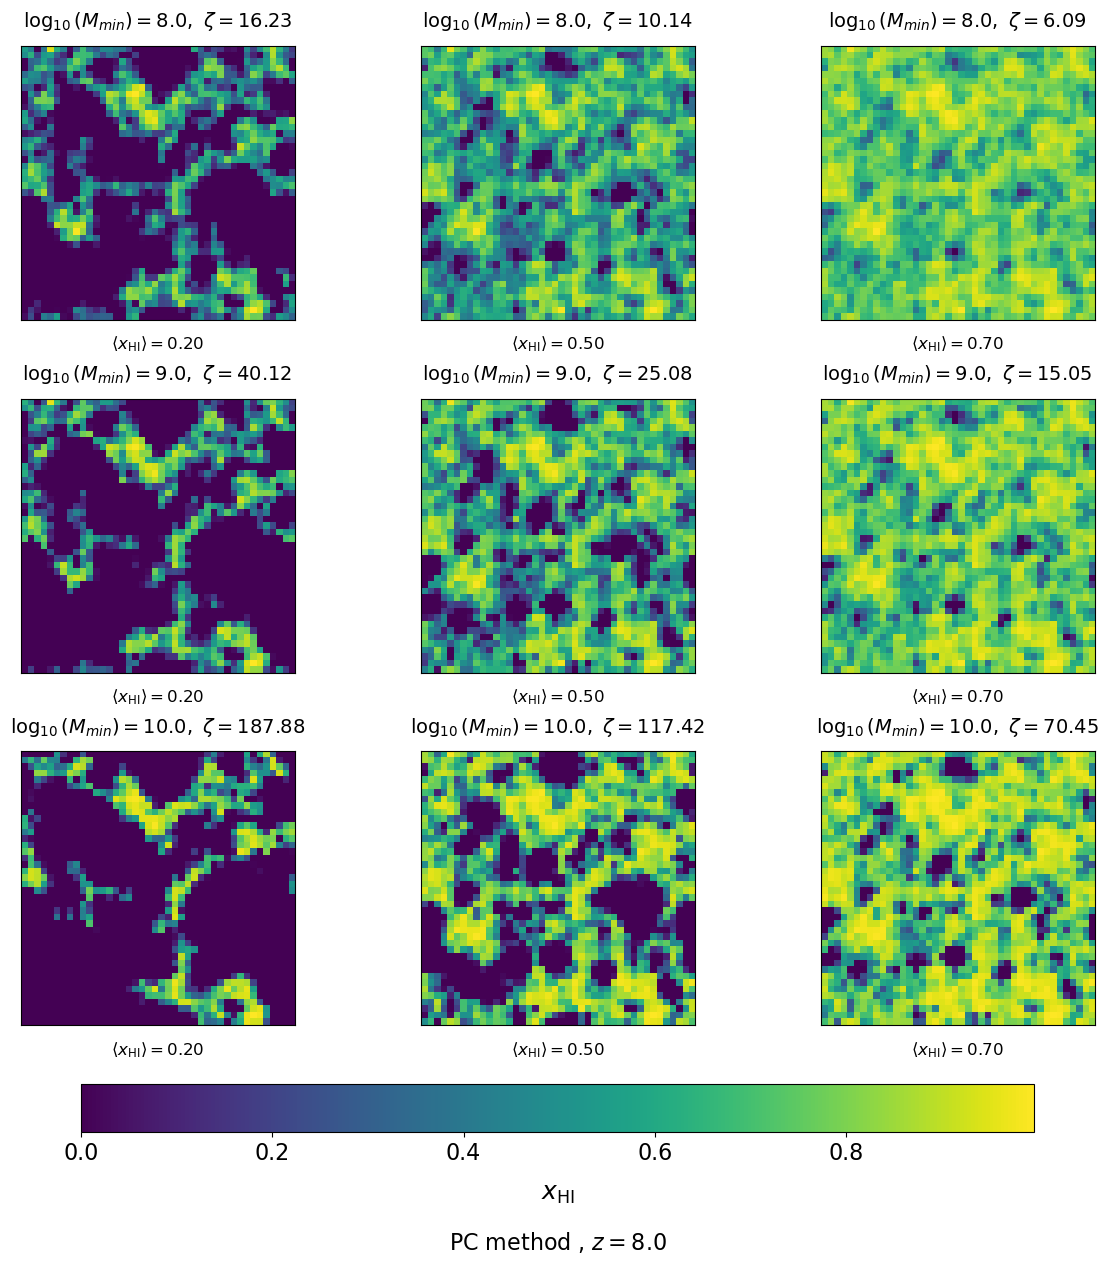

In [9]:

#3:
nrows, ncols = 3, 3  # 3 log10Mmin, 3 zeta per log10Mmin
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4 * ncols, 4 * nrows), constrained_layout=True)

for j in range(9):
    i = j // 3         # which log10Mmin (row)
    k = j % 3          # which zeta within that Mmin group (column)
    
    log10Mmin = list_log10Mmin_vals[i]
    zeta = zeta_vals2[j]
    xhi=list_xhi_vals[k]

    fcoll_arr = matter_fields.get_fcoll_for_Mmin(log10Mmin)
    print("log10(Mmin):", log10Mmin, "fcoll:", fcoll_arr.mean())
    print("zeta:", zeta)

    ionization_map = script.ionization_map(matter_fields)
    qi_arr = ionization_map.get_qi(zeta * fcoll_arr)
    print("qi_arr mean:", qi_arr.mean())

    ax = axes[i, k]  # correct subplot position

    im = ax.imshow(
        1 - qi_arr[:, :, int(0.5*ngrid)],
        extent=[0, default_simulation_data.box, 0, default_simulation_data.box],
        cmap='viridis'
    )
    ax.set_title(rf"$\log_{{10}}(M_{{min}})={log10Mmin},\ \zeta={zeta:.2f}$",
                 fontsize=14,
                 pad=14)
    ax.set_xticks([])
    ax.set_yticks([])

    ax.text(
        0.5, -0.05,
        f"$\\langle x_{{\\mathrm{{HI}}}} \\rangle = {xhi:.2f}$", #1 - qi_arr.mean():.2f
        fontsize=12,
        ha='center',
        va='top',
        transform=ax.transAxes
    )
fig.text(
    0.5, -0.02, rf'PC method , $z={default_simulation_data.z:.1f}$',
    fontsize=16,
    ha='center',
    va='top'
)

cbar = fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.8, pad=0.02,
                    label=r'$x_{\mathrm{HI}}$', orientation='horizontal')
cbar.ax.tick_params(labelsize=16)
cbar.set_label(r'$x_{\mathrm{HI}}$', fontsize=18, labelpad=12)
plt.show()




log10(Mmin): 8.0 fcoll: 0.046404514
zeta: 16.227490734768995
qi_arr mean: 0.7722957
log10(Mmin): 8.0 fcoll: 0.046404514
zeta: 10.142181709230622
qi_arr mean: 0.471485
log10(Mmin): 8.0 fcoll: 0.046404514
zeta: 6.085309025538375
qi_arr mean: 0.28238678
log10(Mmin): 9.0 fcoll: 0.018346127
zeta: 40.12469013834109
qi_arr mean: 0.7715894
log10(Mmin): 9.0 fcoll: 0.018346127
zeta: 25.077931336463177
qi_arr mean: 0.46450168
log10(Mmin): 9.0 fcoll: 0.018346127
zeta: 15.046758801877909
qi_arr mean: 0.2762321
log10(Mmin): 10.0 fcoll: 0.0037661456
zeta: 187.87921772097275
qi_arr mean: 0.773292
log10(Mmin): 10.0 fcoll: 0.0037661456
zeta: 117.42451107560797
qi_arr mean: 0.45962998
log10(Mmin): 10.0 fcoll: 0.0037661456
zeta: 70.4547066453648
qi_arr mean: 0.26834342


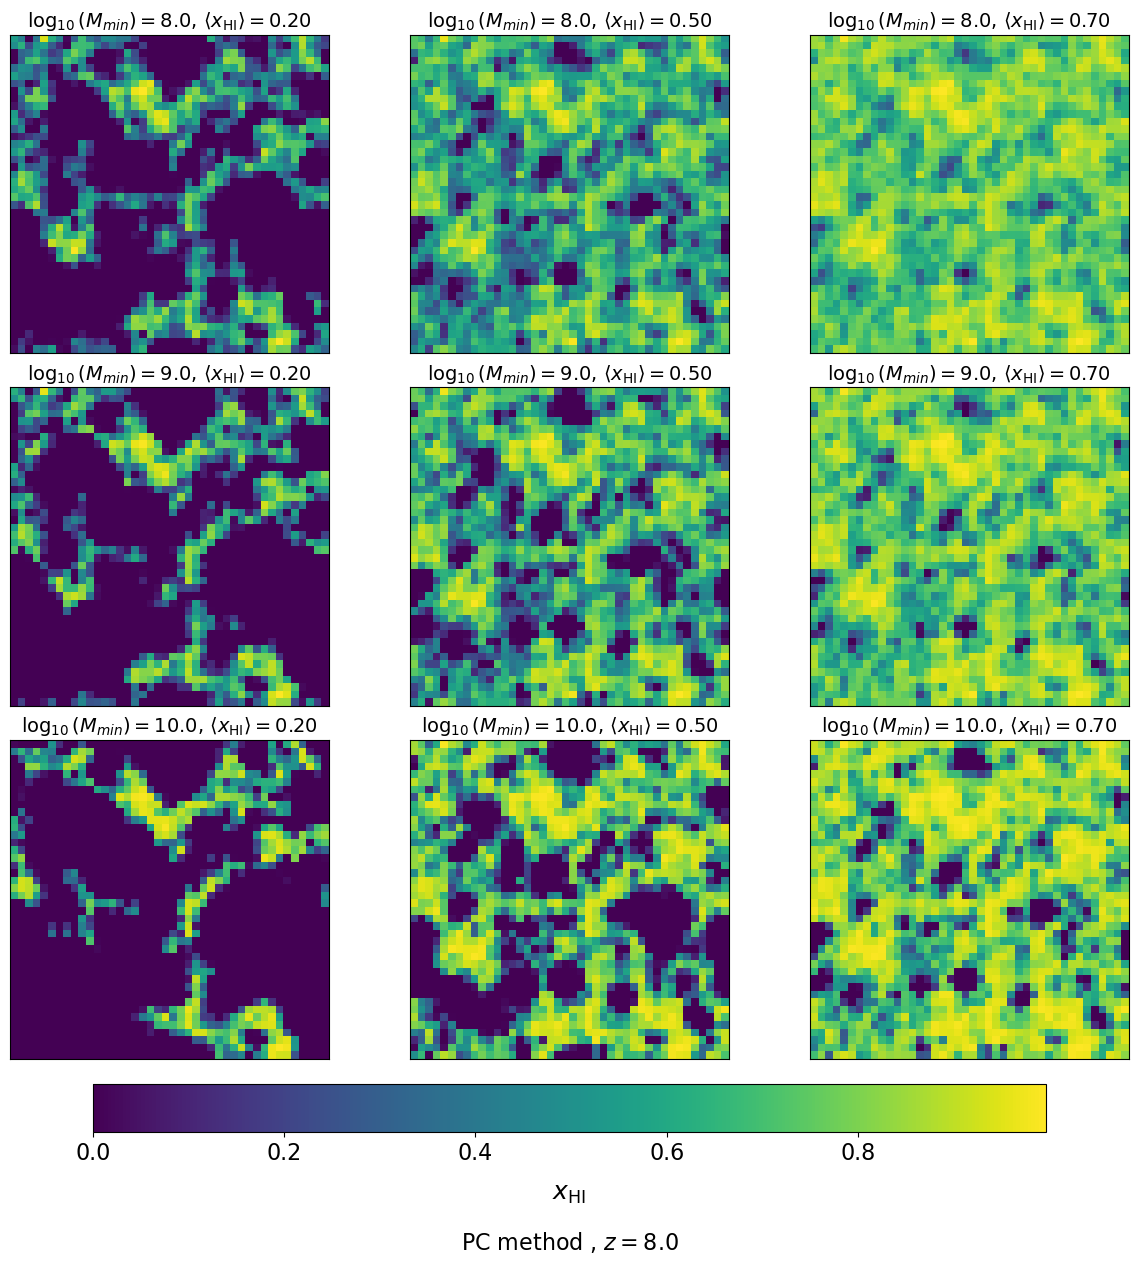

In [10]:
#extra version of the plot with the PC method
#for better visualization 


#3:
nrows, ncols = 3, 3  # 3 log10Mmin, 3 zeta per log10Mmin
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4 * ncols, 4 * nrows), constrained_layout=True)

for j in range(9):
    i = j // 3         # which log10Mmin (row)
    k = j % 3          # which zeta within that Mmin group (column)
    
    log10Mmin = list_log10Mmin_vals[i]
    zeta = zeta_vals2[j]
    xhi=list_xhi_vals[k]

    fcoll_arr = matter_fields.get_fcoll_for_Mmin(log10Mmin)
    print("log10(Mmin):", log10Mmin, "fcoll:", fcoll_arr.mean())
    print("zeta:", zeta)

    ionization_map = script.ionization_map(matter_fields)
    qi_arr = ionization_map.get_qi(zeta * fcoll_arr)
    print("qi_arr mean:", qi_arr.mean())

    ax = axes[i, k]  #correct subplot position

    im = ax.imshow(
        1 - qi_arr[:, :, int(0.5*ngrid)],
        extent=[0, default_simulation_data.box, 0, default_simulation_data.box],
        cmap='viridis'
    )
    ax.set_title(rf"$\log_{{10}}(M_{{min}})={log10Mmin}$, " + rf"$\langle x_{{\mathrm{{HI}}}} \rangle = {xhi:.2f}$",
                 fontsize=14)
    ax.set_xticks([])
    ax.set_yticks([])

fig.text(
    0.5, -0.02, rf'PC method , $z={default_simulation_data.z:.1f}$',
    fontsize=16,
    ha='center',
    va='top'
)

cbar = fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.8, pad=0.02,
                    label=r'$x_{\mathrm{HI}}$', orientation='horizontal')
cbar.ax.tick_params(labelsize=16)
cbar.set_label(r'$x_{\mathrm{HI}}$', fontsize=18, labelpad=12)
plt.show()

log10(Mmin): 8.0 fcoll: 0.046404514
zeta: 16.227490734768995
qi_arr mean: 0.7722957
log10(Mmin): 8.0 fcoll: 0.046404514
zeta: 10.142181709230622
qi_arr mean: 0.471485
log10(Mmin): 8.0 fcoll: 0.046404514
zeta: 6.085309025538375
qi_arr mean: 0.28238678
log10(Mmin): 9.0 fcoll: 0.018346127
zeta: 40.12469013834109
qi_arr mean: 0.7715894
log10(Mmin): 9.0 fcoll: 0.018346127
zeta: 25.077931336463177
qi_arr mean: 0.46450168
log10(Mmin): 9.0 fcoll: 0.018346127
zeta: 15.046758801877909
qi_arr mean: 0.2762321
log10(Mmin): 10.0 fcoll: 0.0037661456
zeta: 187.87921772097275
qi_arr mean: 0.773292
log10(Mmin): 10.0 fcoll: 0.0037661456
zeta: 117.42451107560797
qi_arr mean: 0.45962998
log10(Mmin): 10.0 fcoll: 0.0037661456
zeta: 70.4547066453648
qi_arr mean: 0.26834342


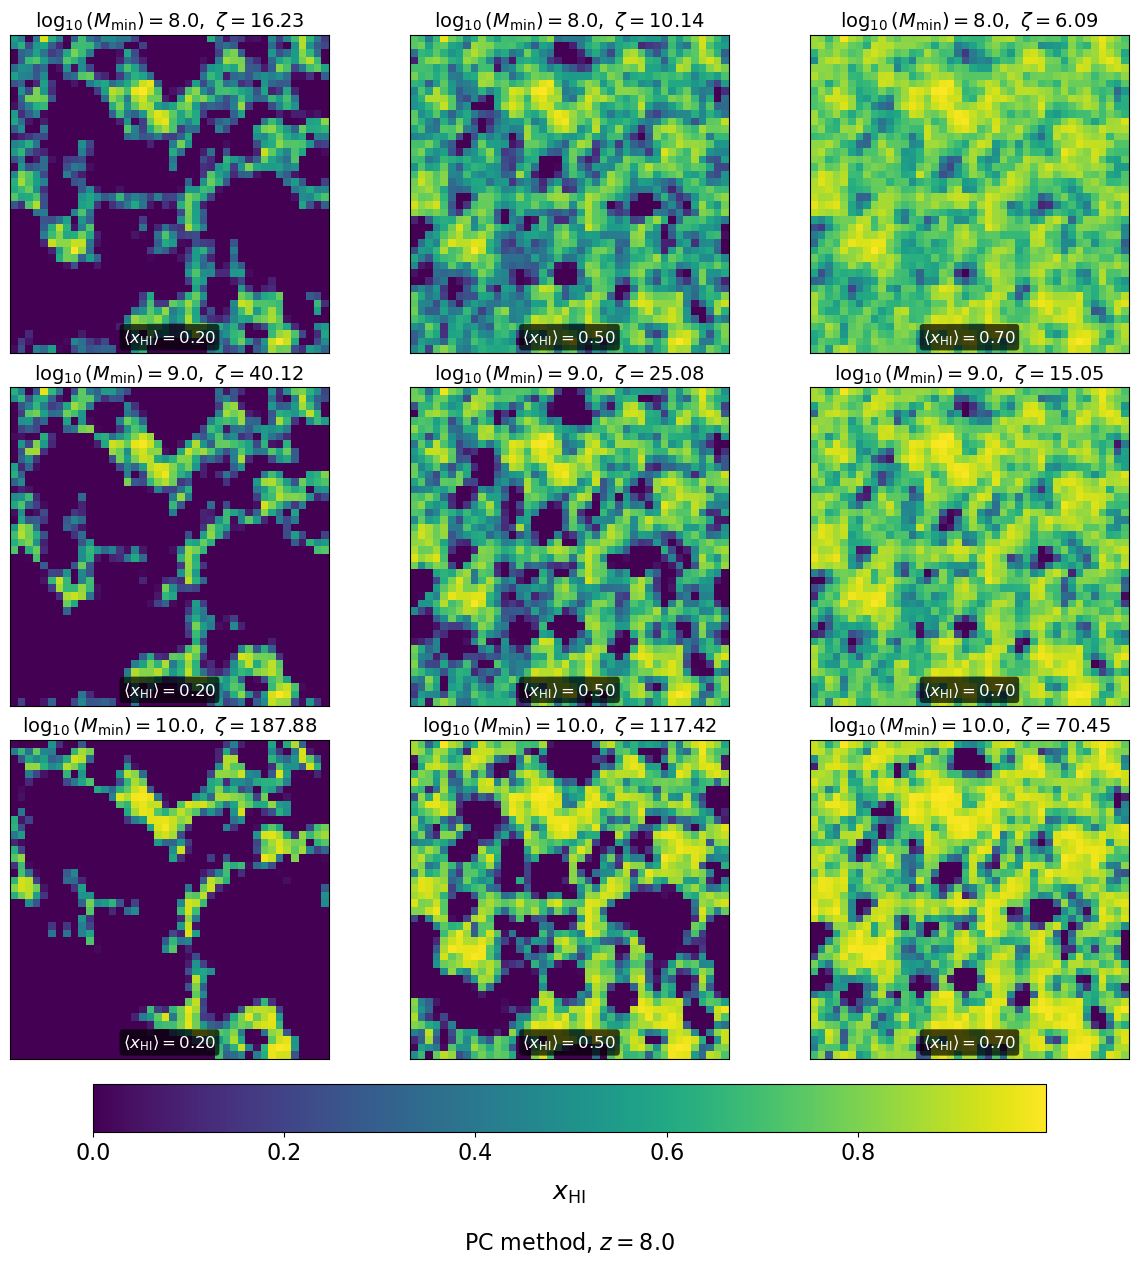

In [11]:
nrows, ncols = 3, 3  # 3 log10Mmin, 3 zeta per log10Mmin
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4 * ncols, 4 * nrows), constrained_layout=True)

for j in range(9):
    i = j // 3         # which log10Mmin (row)
    k = j % 3          # which zeta within that Mmin group (column)

    log10Mmin = list_log10Mmin_vals[i]
    zeta = zeta_vals2[j]
    xhi=list_xhi_vals[k]  # Assuming this corresponds to zeta_es_vals[j]

    fcoll_arr = matter_fields.get_fcoll_for_Mmin(log10Mmin)
    print("log10(Mmin):", log10Mmin, "fcoll:", fcoll_arr.mean())
    print("zeta:", zeta)

    ionization_map = script.ionization_map(matter_fields)
    qi_arr = ionization_map.get_qi(zeta * fcoll_arr)
    print("qi_arr mean:", qi_arr.mean())

    ax = axes[i, k]

    im = ax.imshow(
        1 - qi_arr[:, :, int(0.5*ngrid)],
        extent=[0, default_simulation_data.box, 0, default_simulation_data.box],
        cmap='viridis'
    )

    # Title only with Mmin and zeta
    ax.set_title(
        rf"$\log_{{10}}(M_{{\min}})={log10Mmin},\ \zeta={zeta:.2f}$",
        fontsize=14
    )
    ax.set_xticks([])
    ax.set_yticks([])

    #white label ⟨x_HI⟩ inside each panel
    ax.text(
        0.5, 0.02,  # small margin from bottom
        rf"$\langle x_{{\mathrm{{HI}}}} \rangle = {xhi:.2f}$",
        fontsize=12,
        ha='center',
        va='bottom',
        color='white',
        transform=ax.transAxes,
        bbox=dict(facecolor='black', alpha=0.7, edgecolor='none', boxstyle='round,pad=0.2')
    )


fig.text(
    0.5, -0.02, rf'PC method, $z={default_simulation_data.z:.1f}$',
    fontsize=16,
    ha='center',
    va='top'
)


cbar = fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.8, pad=0.02,
                    label=r'$x_{\mathrm{HI}}$', orientation='horizontal')
cbar.ax.tick_params(labelsize=16)
cbar.set_label(r'$x_{\mathrm{HI}}$', fontsize=18, labelpad=12)

plt.show()